In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Import data

In [2]:
train_df = pd.read_csv('../raw_data/train.csv')
test_df = pd.read_csv('../raw_data/test.csv')
submission_df = pd.read_csv('../raw_data/sample_submission.csv')

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Data exploration

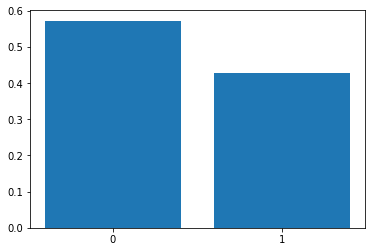

In [224]:
plt.bar((train_df['target'].value_counts()/len(train_df)).index,train_df['target'].value_counts()/len(train_df))
plt.xticks(ticks=train_df['target'].unique())
plt.show()

Target classes are slightly imbalanced, but shouldn't be a problem (bigger class <70%).

### Preprocessing

#### Basic for all types of data

In [5]:
train_df.isnull().sum()/len(train_df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

First model won't use location. Given that there are less than 1% of tweets missing keyword, I'll drop the rows with NaNs in that column

In [6]:
train_df = train_df[train_df['keyword'].notna()]

In [7]:
len(train_df.drop_duplicates()) == len(train_df)

True

No duplicates found

In [8]:
X_train = train_df.drop(columns=['target','location'])
y_train = train_df['target']

#### Basic for text

Create custom transformer for basic text preprocessing. Easier to play around later on.

In [10]:
def remove_digits(string):
    """Remove digits from the given string"""
    return ''.join(letter for letter in string if not letter.isdigit())

In [11]:
from nltk.tokenize import word_tokenize

def tokenize(string):
    """Returns list of words componing the string"""
    return word_tokenize(string)

def detokenize(tokenized_string):
    return ' '.join(tokenized_string)

In [12]:
def remove_stopwords(tokenized_string, stopwords):
    """Given a list of words, removes all words that are in stopwords"""
    return [word for word in tokenized_string if word not in stopwords]

In [13]:
from nltk.stem import WordNetLemmatizer

def lemmatize(tokenized_string):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokenized_string]

In [56]:
from sklearn.base import TransformerMixin, BaseEstimator
import string
from nltk.corpus import stopwords

class BasicTextProcessor(TransformerMixin, BaseEstimator):
    """
    Transformer that gets fed pd.Series containing text. Can be defined which actions should be executed:
    - lower
    - remove user tags
    - remove special programming characters
    - remove links
    - remove digits
    - exclude certain types of punctuation (everything else will be removed)
    - exclude certain stopwords (everything else will be removed)
    - lemmatize
    """
    def __init__(self, lower=True, remove_tags=True, remove_specials=[r'&amp;', r'\\n'], remove_links=True, remove_num=True, excl_punct=None, excl_stopwords=None, lemmatize=True):
        self.lower = lower
        self.remove_tags = remove_tags
        self.remove_specials = remove_specials
        self.remove_links = remove_links
        self.remove_num = remove_num
        self.excl_punct = excl_punct
        self.excl_stopwords = excl_stopwords
        self.lemmatize = lemmatize
    
    def fit(self, X, y=None):
        if self.excl_punct:
            self.punctuation = ''.join(i for i in string.punctuation if i not in self.excl_punct)
        else:
            self.punctuation = string.punctuation
        if self.excl_stopwords:
            self.stopwords = [i for i in stopwords.words("english") if i not in self.excl_stopwords]
        else:
            self.stopwords = stopwords.words("english")
        
        return self
    
    def transform(self, X, y=None):
        X_transformed = X['text'].copy()
        
        if self.remove_specials:
            for special in self.remove_specials:
                X_transformed = X_transformed.str.replace(special,' ',regex=True)
        if self.lower:
            X_transformed = X_transformed.str.lower()
        if self.remove_tags:
            X_transformed = X_transformed.str.replace(r'@(\w+)','USER',regex=True)
        if self.remove_links:
            X_transformed = X_transformed.str.replace(r'http(\S+)','LINK',regex=True)
        if self.remove_num:
            X_transformed = X_transformed.apply(remove_digits)
        
        # substitute ' with space for better removal of stopwords
        if "'" in self.punctuation:
            X_transformed = X_transformed.str.replace("'",' ',regex=False)
        for punct in self.punctuation:
            X_transformed = X_transformed.str.replace(punct,'',regex=False)
        
        # actions on tokenized string
        X_transformed_tokenized = X_transformed.apply(tokenize)
        X_transformed_tokenized = X_transformed_tokenized.apply(remove_stopwords,stopwords=self.stopwords)
        X_transformed_tokenized = X_transformed_tokenized.apply(lemmatize)
        
        return X_transformed_tokenized.apply(detokenize)

#### Build basic pipeline for tweets

In [57]:
from sklearn import set_config
set_config(display="diagram")

In [147]:
from sklearn.pipeline import Pipeline

basic_pipe = Pipeline([
    ('basic', BasicTextProcessor())
])

basic_pipe

Pipeline(steps=[('basic', BasicTextProcessor())])

#### Embeddings

Output for word2vec embedding is multiple rows for each sentence. How do we put them back together so that they are represented by a single vector?
One idea is to sum (or better, average) all the vectors generated by each word in the sentence.

In [131]:
def embed_sentence(sentence, word2vec):
    """Given tokenized sentence, uses word2vec to get vector representation of words.
    Returns the mean vector for each sentence"""
    embedded_words = [word2vec.wv[word] for word in sentence if word in word2vec.wv.vocab]
    return np.mean(np.stack(embedded_words,axis=0),axis=0) if embedded_words\
        else np.empty((word2vec.trainables.layer1_size,))

In [156]:
from gensim.models import Word2Vec

class Embedding(TransformerMixin, BaseEstimator):
    """
    Transformer that gets fed pd.Series containing preprocessed text.
    Returns representation in embedding space as df. Some hyperparameters can be defined.
    """
    def __init__(self, size=100, min_count=10, window=5):
        self.size = size
        self.min_count = min_count
        self.window = window
    
    def fit(self, X, y=None):
        X_tokenized = X.apply(tokenize)
        self.word2vec = Word2Vec(sentences=X_tokenized,
                                 size=self.size,
                                 min_count=self.min_count,
                                 window=self.window)
        
        return self
    
    def transform(self, X, y=None):
        X_tokenized = X.apply(tokenize)
        X_transformed = X_tokenized.apply(embed_sentence, word2vec=self.word2vec)
        
        return X_transformed.apply(pd.Series)

#### Vectorize

In [157]:
# bag of words for keyword column, tfidf for tweet column

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

bow = CountVectorizer()
tfidf = TfidfVectorizer(max_df=0.5, max_features=5000, min_df=0, ngram_range=(1,1))

#### Build preprocessing pipeline

In [188]:
from sklearn.preprocessing import MinMaxScaler

tweet_pipe = Pipeline([
    ('basic', basic_pipe),
#     ('embedding', Embedding()),
#     ('scaler', MinMaxScaler())
    ('tfidf', tfidf)
])

tweet_pipe

Pipeline(steps=[('basic', Pipeline(steps=[('basic', BasicTextProcessor())])),
                ('tfidf',
                 TfidfVectorizer(max_df=0.5, max_features=5000, min_df=0))])

In [189]:
from sklearn.compose import ColumnTransformer

preproc_pipe = ColumnTransformer([
    ('tweets', tweet_pipe,['text']),
    ('keywords', bow, 'keyword')
],sparse_threshold=0)

preproc_pipe

ColumnTransformer(sparse_threshold=0,
                  transformers=[('tweets',
                                 Pipeline(steps=[('basic',
                                                  Pipeline(steps=[('basic',
                                                                   BasicTextProcessor())])),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_df=0.5,
                                                                  max_features=5000,
                                                                  min_df=0))]),
                                 ['text']),
                                ('keywords', CountVectorizer(), 'keyword')])

#### Feature engineering?

In [160]:
# could be number of punctuation

### Modelling

#### Standard Machine Learning

In [226]:
# create possibility to choose model from dict

#### Baseline score

In [220]:
baseline = (train_df['target'].value_counts()/len(train_df))[1]
baseline

0.4275688559322034

#### Naive Bayes Algorithm

In [172]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

In [173]:
nb_pipe = Pipeline([
    ('preprocessing', preproc_pipe),
    ('naive_bayes', nb_model)
])

nb_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('tweets',
                                                  Pipeline(steps=[('basic',
                                                                   Pipeline(steps=[('basic',
                                                                                    BasicTextProcessor())])),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.5,
                                                                                   max_features=5000,
                                                                                   min_df=0))]),
                                                  ['text']),
                                                 ('keywords', CountVectorizer(),
                                                  'keyword')])),
                ('naive_bayes', MultinomialNB())])

In [174]:
from sklearn.model_selection import cross_validate

nb_res = cross_validate(nb_pipe, X_train, y_train, cv=5, scoring='f1')

nb_res['test_score'].mean()

0.5802473173212119

#### Logistic Regression

In [193]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=10000)

In [194]:
logreg_pipe = Pipeline([
    ('preprocessing', preproc_pipe),
    ('logistic_regression', logreg_model)
])

logreg_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('tweets',
                                                  Pipeline(steps=[('basic',
                                                                   Pipeline(steps=[('basic',
                                                                                    BasicTextProcessor())])),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.5,
                                                                                   max_features=5000,
                                                                                   min_df=0))]),
                                                  ['text']),
                                                 ('keywords', CountVectorizer(),
                                                  'keyword')])),
                ('logistic_regression', LogisticRegression(max_iter=10000))])

In [195]:
logreg_res = cross_validate(logreg_pipe, X_train, y_train, cv=5, scoring='f1')

logreg_res['test_score'].mean()

0.5085871294271807

#### KNN

In [190]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

In [191]:
knn_pipe = Pipeline([
    ('preprocessing', preproc_pipe),
    ('knn', knn_model)
])

knn_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('tweets',
                                                  Pipeline(steps=[('basic',
                                                                   Pipeline(steps=[('basic',
                                                                                    BasicTextProcessor())])),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.5,
                                                                                   max_features=5000,
                                                                                   min_df=0))]),
                                                  ['text']),
                                                 ('keywords', CountVectorizer(),
                                                  'keyword')])),
                ('knn', KNeighborsClassifier())])

In [192]:
knn_res = cross_validate(knn_pipe, X_train, y_train, cv=5, scoring='f1')

knn_res['test_score'].mean()

0.47201329583744267

#### Deep Learning

In [225]:
# use embeddings only for RNN